# import libraries



In [1]:
!pip install -q tensorflow-datasets nbformat

In [2]:
import os, json, nbformat
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# helper plotting functions


In [3]:
def plot_history(history, title="Training"):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history.get('val_accuracy', []), label='val_acc')
    plt.title(f"{title} — Accuracy"); plt.xlabel("Epoch"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history.get('val_loss', []), label='val_loss')
    plt.title(f"{title} — Loss"); plt.xlabel("Epoch"); plt.legend()
    plt.show()

In [4]:
def show_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.colorbar(); plt.show()

# A) MNIST

In [5]:
print("\n=== MNIST quick model ===")
(ds_mnist_train, ds_mnist_test), mnist_info = tfds.load(
    'mnist', split=['train','test'], as_supervised=True, with_info=True)

IMG = 28
AUTOTUNE = tf.data.AUTOTUNE
MNIST_BATCH = 256

def preprocess_mnist(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [IMG,IMG,1])
    return image, label

mnist_train = ds_mnist_train.map(preprocess_mnist, num_parallel_calls=AUTOTUNE).shuffle(10000).batch(MNIST_BATCH).prefetch(AUTOTUNE)
mnist_test  = ds_mnist_test.map(preprocess_mnist, num_parallel_calls=AUTOTUNE).batch(MNIST_BATCH).prefetch(AUTOTUNE)

def build_mnist_model():
    inp = tf.keras.Input((IMG,IMG,1))
    x = tf.keras.layers.Conv2D(32,3,padding='same',activation='relu')(inp)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64,3,padding='same',activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    out = tf.keras.layers.Dense(10,activation='softmax')(x)
    return tf.keras.Model(inp,out)

mnist_model = build_mnist_model()
mnist_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

mnist_ckpt = "mnist_best.keras"


=== MNIST quick model ===


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.GW9XC4_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.GW9XC4_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [6]:
mnist_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(mnist_ckpt, monitor='val_accuracy', save_best_only=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1)
]

Training MNIST...
Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.97490, saving model to mnist_best.keras
235/235 - 20s - 87ms/step - accuracy: 0.8890 - loss: 0.3643 - val_accuracy: 0.9749 - val_loss: 1.2552 - learning_rate: 1.0000e-03
Epoch 2/10

Epoch 2: val_accuracy improved from 0.97490 to 0.98450, saving model to mnist_best.keras
235/235 - 4s - 16ms/step - accuracy: 0.9628 - loss: 0.1274 - val_accuracy: 0.9845 - val_loss: 0.1420 - learning_rate: 1.0000e-03
Epoch 3/10

Epoch 3: val_accuracy improved from 0.98450 to 0.98620, saving model to mnist_best.keras
235/235 - 4s - 16ms/step - accuracy: 0.9729 - loss: 0.0922 - val_accuracy: 0.9862 - val_loss: 0.0420 - learning_rate: 1.0000e-03
Epoch 4/10

Epoch 4: val_accuracy improved from 0.98620 to 0.98840, saving model to mnist_best.keras
235/235 - 4s - 19ms/step - accuracy: 0.9765 - loss: 0.0782 - val_accuracy: 0.9884 - val_loss: 0.0364 - learning_rate: 1.0000e-03
Epoch 5/10

Epoch 5: val_accuracy improved from 0.98840 to 0.989

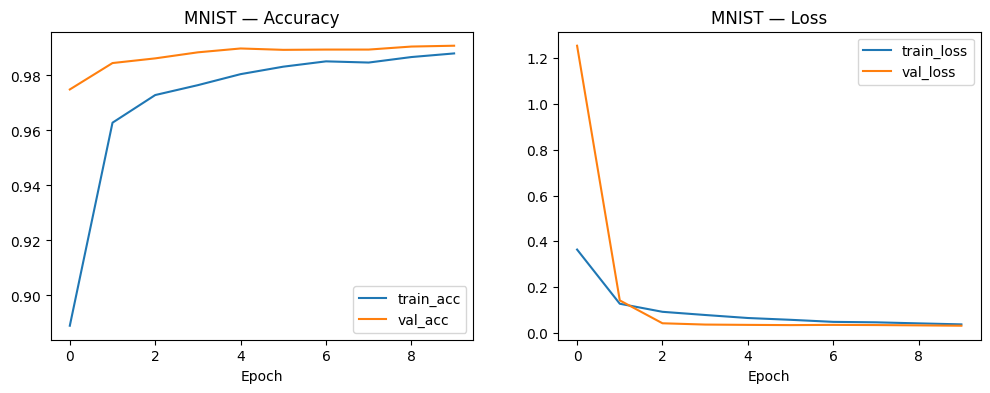

40/40 - 0s - 7ms/step - accuracy: 0.9908 - loss: 0.0313
MNIST test accuracy: 99.08%


In [7]:
print("Training MNIST...")
hist_mnist = mnist_model.fit(mnist_train, validation_data=mnist_test, epochs=10, callbacks=mnist_callbacks, verbose=2)
plot_history(hist_mnist, "MNIST")
mnist_eval = mnist_model.evaluate(mnist_test, verbose=2)
print(f"MNIST test accuracy: {mnist_eval[1]*100:.2f}%")

# B) EMNIST

In [8]:
print("\n=== EMNIST advanced pipeline ===")
(ds_emnist_train, ds_emnist_test), emnist_info = tfds.load(
    'emnist/balanced', split=['train','test'], as_supervised=True, with_info=True)
print("EMNIST classes:", emnist_info.features['label'].num_classes)

def preprocess_emnist(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.transpose(image, perm=[1,0,2])   # rotate 90
    image = tf.image.flip_left_right(image)     # flip to upright
    image = tf.reshape(image, [IMG,IMG,1])
    return image, label



=== EMNIST advanced pipeline ===


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/incomplete.APRRHP_3.1.0/emnist-train.tfrecord*...:   0%|  …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/incomplete.APRRHP_3.1.0/emnist-test.tfrecord*...:   0%|   …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/balanced/3.1.0. Subsequent calls will reuse this data.
EMNIST classes: 47


In [9]:
EMNIST_BATCH = 256
emnist_train = ds_emnist_train.map(preprocess_emnist, num_parallel_calls=AUTOTUNE).shuffle(100000).batch(EMNIST_BATCH).prefetch(AUTOTUNE)
emnist_test  = ds_emnist_test.map(preprocess_emnist, num_parallel_calls=AUTOTUNE).batch(EMNIST_BATCH).prefetch(AUTOTUNE)


In [10]:
# build EMNIST model
from tensorflow.keras import regularizers
def build_emnist_model(num_classes):
    inp = tf.keras.Input((IMG,IMG,1))
    x = tf.keras.layers.Conv2D(64,3,padding='same',activation='relu',kernel_regularizer=regularizers.l2(1e-4))(inp)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Conv2D(128,3,padding='same',activation='relu',kernel_regularizer=regularizers.l2(1e-4))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512,activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    out = tf.keras.layers.Dense(num_classes,activation='softmax')(x)
    return tf.keras.Model(inp,out)

emnist_model = build_emnist_model(emnist_info.features['label'].num_classes)
emnist_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

emnist_ckpt = "emnist_best.keras"

In [11]:
emnist_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(emnist_ckpt, monitor='val_accuracy', save_best_only=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1)
]

Training EMNIST...
Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.30707, saving model to emnist_best.keras
441/441 - 31s - 69ms/step - accuracy: 0.6541 - loss: 1.2179 - val_accuracy: 0.3071 - val_loss: 5.3905 - learning_rate: 1.0000e-03
Epoch 2/15

Epoch 2: val_accuracy improved from 0.30707 to 0.84713, saving model to emnist_best.keras
441/441 - 11s - 26ms/step - accuracy: 0.7892 - loss: 0.6568 - val_accuracy: 0.8471 - val_loss: 0.4612 - learning_rate: 1.0000e-03
Epoch 3/15

Epoch 3: val_accuracy improved from 0.84713 to 0.86059, saving model to emnist_best.keras
441/441 - 11s - 25ms/step - accuracy: 0.8145 - loss: 0.5678 - val_accuracy: 0.8606 - val_loss: 0.4205 - learning_rate: 1.0000e-03
Epoch 4/15

Epoch 4: val_accuracy improved from 0.86059 to 0.86941, saving model to emnist_best.keras
441/441 - 12s - 27ms/step - accuracy: 0.8277 - loss: 0.5209 - val_accuracy: 0.8694 - val_loss: 0.4087 - learning_rate: 1.0000e-03
Epoch 5/15

Epoch 5: val_accuracy did not improve from 0

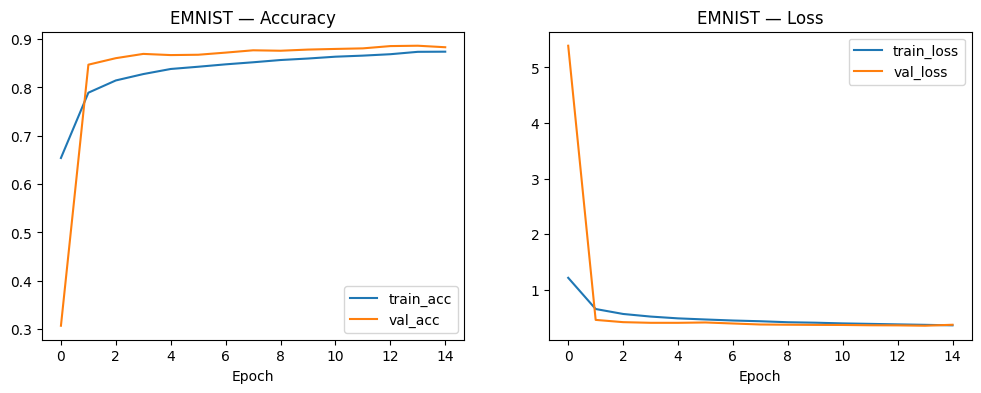

74/74 - 1s - 18ms/step - accuracy: 0.8863 - loss: 0.3563
EMNIST test accuracy: 88.63%


In [12]:
print("Training EMNIST...")
hist_emnist = emnist_model.fit(emnist_train, validation_data=emnist_test, epochs=15, callbacks=emnist_callbacks, verbose=2)
plot_history(hist_emnist, "EMNIST")
emnist_eval = emnist_model.evaluate(emnist_test, verbose=2)
print(f"EMNIST test accuracy: {emnist_eval[1]*100:.2f}%")


In [15]:
print(f"MNIST test accuracy: {mnist_eval[1]*100:.2f}%")
print(f"EMNIST test accuracy: {emnist_eval[1]*100:.2f}%")


MNIST test accuracy: 99.08%
EMNIST test accuracy: 88.63%
